In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy.special import lpmn
import pandas as pd
from datetime import datetime
import sympy as sym
import csv
from filterpy.kalman import ExtendedKalmanFilter
from fp_utils import *

In [2]:
#read in LEO_DATA_APPARENT.csv
leo_app = "LEO_DATA_Apparent_3Days.csv"

#observations column names
column_names = ['id', 'time', 'range', 'range_rate']

#observations dataframe
obs_df = pd.read_csv(leo_app, names=column_names)

In [3]:
#constants
mu = 398600.4415*1000**3 #m^3/s^2
# R_earth = 6378.137 #km

e_earth = 0.0818191908426215
omega_earth = 7.2921158553E-5 #rad/s
AU = 149597870.7 #km

#initial state
r_ECI = np.array([6984.45711518852, 1612.2547582643, 13.0925904314402])*1000 #m
# r_ECI = np.array([6984.46459301679,	1612.22237259524,	13.0914313353482])*1000 #m
v_ECI = np.array([-1.67667852227336, 7.26143715396544, 0.259889857225218])*1000 #m/s
# v_ECI = np.array([-1.67664476668291,	7.26144494619245,	0.259889921085112])*1000 #m/s

#station locations
stations = np.array([[-6143584, 1364250, 1033743], 
                    [1907295, 6030810, -817119],
                    [2390310, -5564341 , 1994578]]) #m

#time
JD_UTC = gregorian_to_jd(2018, 3, 23, 8, 55, 3)
leap_sec = 37 #s
x_p = np.array([20.816, 22.156, 23.439, 24.368, 25.676, 26.952, 28.108])/1000 #arcsec
y_p = np.array([381.008, 382.613, 384.264, 385.509, 386.420, 387.394, 388.997])/1000 #arcsec
del_UT1 = np.array([144.0585, 143.1048, 142.2335, 141.3570, 140.4078, 139.3324, 138.1510])/1000



In [4]:
def satellite_motion_EGM96(t, y, JD_UTC):
    r_ECI = y[0:3]
    r_dot = y[3:6]
    JD_UTC += t/86400
    leap_sec = 37 #s
    x_p = 15.361/1000 #arcsec
    y_p = 288.259/1000 #arcsec
    del_UT1 = 196.5014 #s

    g_ECEF = F_gravity_vallado(r_ECI)
    g_ECI = ECEF2ECI(g_ECEF, JD_UTC, leap_sec, x_p, y_p, del_UT1)
    r_ddot = g_ECI

    return np.concatenate([r_dot, r_ddot])

In [5]:
#Initialize Extended Kalman Filter

phi = np.eye(7)
y0 = np.concatenate((r_ECI, v_ECI, [1.88]))

#initial covariance

P_hat_0 = np.diag([10E3, 10E3, 10E3, 1E2, 1E2, 1E2, 1E-6])

#process noise
sigma_x = 1E-10
sigma_y = 1E-10
sigma_z = 1E-10

del_t = sym.Symbol('del_t')
Q_sym = del_t**2*sym.Matrix([[del_t**2/4*sigma_x**2, 0, 0, del_t**2/2*sigma_x**2, 0, 0, 0],
                         [0, del_t**2/4*sigma_y**2, 0, 0, del_t**2/2*sigma_y**2, 0, 0],
                         [0, 0, del_t**2/4*sigma_z**2, 0, 0, del_t**2/2*sigma_z**2, 0],
                         [del_t**2/2*sigma_x**2, 0, 0, del_t**2*sigma_x**2, 0, 0, 0],
                         [0, del_t**2/2*sigma_y**2, 0, 0, del_t**2*sigma_y**2, 0, 0],
                         [0, 0, del_t**2/2*sigma_z**2, 0, 0, del_t**2*sigma_z**2, 0],
                         [0, 0, 0, 0, 0, 0, 0]])

Q = sym.lambdify(del_t, Q_sym, 'numpy')

#measurement noise
sigma_rho = 5 #m
sigma_rho_dot = 0.001 #m/s
R = np.diag([sigma_rho**2, sigma_rho_dot**2])

#time
t = obs_df['time'][0:11].values
print(t)
#initial state
y = y0

#initial covariance
# sigma_x = 1E6 #m
# sigma_y = 1E6 #m
# sigma_z = 1E6 #m
# sigma_vx = 1E3 #m/s
# sigma_vy = 1E3 #m/s
# sigma_vz = 1E3 #m/s
# sigma_C_D = 1e-6

# P_hat_0 = np.array([sigma_x**2 , 0, 0, 0, 0, 0, 0,
#                     0, sigma_y**2, 0, 0, 0, 0, 0,
#                     0, 0, sigma_z**2, 0, 0, 0, 0,
#                     0, 0, 0, sigma_vx**2, 0, 0, 0,
#                     0, 0, 0, 0, sigma_vy**2, 0, 0,
#                     0, 0, 0, 0, 0, sigma_vz**2, 0,
#                     0, 0, 0, 0, 0, 0, sigma_C_D**2])

# P_hat_0 = np.eye(7)*1e-6
# print(P_hat_0.shape)

#jacobians
F = A_Matrix()
H = H_tilde_matrix()

#propogation function 
f = satellite_motion_phi

#measurement function
h = range_range_rate

#initializing arrays
y_arr = np.zeros((len(t), 7))
P_bar = np.zeros((len(t), 7*7))
P_hat = np.zeros((len(t), 7*7))
y_arr[0] = y
P_bar[0] = np.eye(7).reshape(7*7)
P_hat[0] = np.reshape(P_hat_0, 7*7)

#first observation
y_pred = np.concatenate((r_ECI, v_ECI, [1.88]))
del_t = 0
Q_i = Q(del_t)
phi = np.eye(7)

#propogate covariance
P_hat_k = P_hat[0].reshape(7,7)
P_bar_k_1 = np.matmul(np.matmul(phi, P_hat_k), phi.T) + Q_i
# print(P_bar_k_1)
P_bar[0] = np.reshape(P_bar_k_1, 7*7)

#calculate kalman gain
station = stations[obs_df['id'][0]-1]
ECI_station = ECEF2ECI(station, JD_UTC, leap_sec, x_p[0], y_p[0], del_UT1[0])

y_lt = light_time_correction(JD_UTC, r_ECI, v_ECI, station)
print('ECI_station', ECI_station/1000)
print('y_lt', y_lt/1000)
H_k = np.array(H(y_lt[0], y_lt[1], y_lt[2], y_lt[3], y_lt[4], y_lt[5], ECI_station[0], ECI_station[1], ECI_station[2], 1.88))
# print('H_k', H_k)

obs_pred = np.array(range_range_rate(y_lt[0:3], y_lt[3:6], ECI_station))
print('pred_obs' , obs_pred/1000)
print('Obs Range_rate', np.array([obs_df['range'][0], obs_df['range_rate'][0]]))
b = np.array([obs_df['range'][0], obs_df['range_rate'][0]])*1000 - obs_pred

print('b', b/1000)
K = np.matmul(np.matmul(P_bar_k_1, H_k.T), np.linalg.inv(np.matmul(np.matmul(H_k, P_bar_k_1), H_k.T) + R))
# print('K', K)

#state error estimate
del_y = np.matmul(K, b)
# print(del_y)

#error covariance estimate
P_hat[0] = np.reshape(np.matmul(np.matmul(np.eye(7) - np.matmul(K, H_k), P_bar_k_1), (np.eye(7) - np.matmul(K, H_k)).T) + np.matmul(np.matmul(K, R), K.T), 7*7)

#state estimate
y_arr[0] = y_pred + del_y

print('y_arr', y_arr[0]/1000)


[  0.  60. 120. 180. 240. 300. 360. 420. 480. 540. 600.]
ECI_station [5645.37224047 2850.03959899 -826.54309266]
y_lt [ 6.98446834e+03  1.61220613e+03  1.30908501e+01 -1.67662784e+00
  7.26144885e+00  2.59889952e-01]
pred_obs [2007.58442485   -5.09445109]
Obs Range_rate [2004.1      -5.0702]
b [-3.48442485  0.02425109]
y_arr [ 6.98214119e+03  1.61440271e+03  1.16422122e+01 -1.66051380e+00
  7.24649481e+00  2.70025389e-01  1.88000000e-03]


In [6]:
#run EKF
for k in range(1, len(t)):
    del_t = t[k] - t[k-1]
    
    #initial conditions for propogation
    y0 = np.concatenate((y_arr[k-1][0:6], phi.ravel()))

    #propogate state
    prop = solve_ivp(f, [t[k-1], t[k]], y0, args=(F, JD_UTC), rtol=3E-14, atol=1E-16)
    y_pred = np.append(prop.y[0:6, -1], 1.88)
    phi = prop.y[6:, -1].reshape(7, 7)
    # #calculate jacobian

    # #gravity parameters
    # J_2 = 0.00108248

    # #drag parameters
    # A_Cross = 6 #[m^2]
    # C_D = 1.88

    # #solar
    # A_Cross_Sol = 15 #[m^2]

    # #third body parameters
    # r_sun = np.zeros((1, 3))
    # r_moon = np.zeros((1, 3))
    # r_sun[0] = sun_position_vector(JD_UTC + t[k]/86400, leap_sec, del_UT1)
    # r_moon[0] = moon_position_vector(JD_UTC + t[k]/86400, leap_sec, del_UT1)
    
    # A_k = F(y_pred[0], y_pred[1], y_pred[2],mu, J_2, y_pred[3], y_pred[4], y_pred[5], C_D, A_Cross, A_Cross_Sol, mu_sun, mu_moon, r_sun, r_moon)
    # phi_dot = np.matmul(A_k, phi)
    
    # phi += phi_dot
    #process noise
    Q_i = Q(del_t)

    #propogate covariance
    P_hat_k = P_hat[k-1].reshape(7,7)
    P_bar_k_1 = np.matmul(np.matmul(phi, P_hat_k), phi.T) + Q_i
    # print(P_bar_k_1.shape)
    P_bar[k] = np.reshape(P_bar_k_1, 7*7)

    #calculate kalman gain
    station = stations[obs_df['id'][k]-1]
    
    ECI_station = ECEF2ECI(station, JD_UTC + t[k]/86400, leap_sec, x_p[0], y_p[0], del_UT1[0])
    # print(ECI_station/1000)
    y_lt = light_time_correction(JD_UTC+t[k]/86400, y_pred[0:3], y_pred[3:6], station)
    # print('y_lt', y_lt)
    H_k = np.array(H(y_lt[0], y_lt[1], y_lt[2], y_lt[3], y_lt[4], y_lt[5], ECI_station[0], ECI_station[1], ECI_station[2], 1.88))
    # print('H_k', H_k)

    obs_pred = np.array(range_range_rate(y_lt[0:3], y_lt[3:6], ECI_station))
    # print('pred_obs' , obs_pred/1000)
    # print('Obs Range_rate', np.array([obs_df['range'][k], obs_df['range_rate'][k]]))
    b = np.array([obs_df['range'][k], obs_df['range_rate'][k]])*1000 - obs_pred
    
    print('b', b/1000)
    K = np.matmul(np.matmul(P_bar_k_1, H_k.T), np.linalg.inv(np.matmul(np.matmul(H_k, P_bar_k_1), H_k.T) + R))
    # print('K', K)
    
    #state error estimate
    del_y = np.matmul(K, b)
    # print(del_y)

    #error covariance estimate
    P_hat[k] = np.reshape(np.matmul(np.matmul(np.eye(7) - np.matmul(K, H_k), P_bar_k_1), (np.eye(7) - np.matmul(K, H_k)).T) + np.matmul(np.matmul(K, R), K.T), 7*7)

    #state estimate
    y_arr[k] = y_pred + del_y
    print('y', y_arr[k])



b [0.17033397 0.00804434]
y [ 6.86875268e+06  2.04663684e+06  2.93300986e+04 -2.11481413e+03
  7.14029129e+03  2.92734196e+02  1.88000000e+00]
b [0.07606085 0.00113899]
y [ 6.72592164e+06  2.46973432e+06  4.97679729e+04 -2.57150851e+03
  6.98874713e+03  3.07473605e+02  1.88000000e+00]
b [-0.0422561  -0.00163878]
y [ 6.55909279e+06  2.88314740e+06  6.81592395e+04 -2.99666209e+03
  6.81596703e+03  3.00705126e+02  1.88000002e+00]
b [-0.46033674 -0.00150286]
y [ 6.36771972e+06  3.28611381e+06  8.57405926e+04 -3.41493446e+03
  6.61550600e+03  2.96549628e+02  1.88000009e+00]
b [-8.93095664e-01 -4.06831601e-04]
y [ 6.15184085e+06  3.67696207e+06  1.01923798e+05 -3.82018847e+03
  6.38960491e+03  2.89515460e+02  1.88000010e+00]
b [-7.57502980e-01 -4.01103724e-04]
y [ 5.91157197e+06  4.05323349e+06  1.18256154e+05 -4.21126862e+03
  6.13861985e+03  2.82040785e+02  1.88000013e+00]
b [-6.88991428e-01 -5.70352619e-04]
y [ 5.64839762e+06  4.41375446e+06  1.34211087e+05 -4.58578389e+03
  5.86391549e+0

In [7]:
#write EKF results to csv
with open('range_rate.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for i in range(0, len(t)):
        r_ECI = y_arr[int(obs_df['time'][i]/60)][0:3]
        v_ECI = y_arr[int(obs_df['time'][i]/60)][3:6]
        JD_UTC_i = JD_UTC + i*60/86400
        station_index = obs_df['id'][i]-1
        station = stations[station_index]
        ECIstation = ECEF2ECI(station, JD_UTC_i, leap_sec, x_p[0], y_p[0], del_UT1[0])

        r_lt = light_time_correction(JD_UTC_i, r_ECI, v_ECI, station)
        rho, rho_dot = range_range_rate(r_lt[0:3], r_lt[3:6], ECIstation)
        writer.writerow([station_index+1, i*60, rho/1000, rho_dot/1000])

Atoll Range RMS: 0.5652859789612498 [km]
Atoll Range Rate RMS: 0.0002783862469192526 [km/s]


/tmp/ipykernel_6606/2842418692.py:31: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  t_atoll = obs_df['time'][obs_df.index[obs_df['id']==2]][0:11]


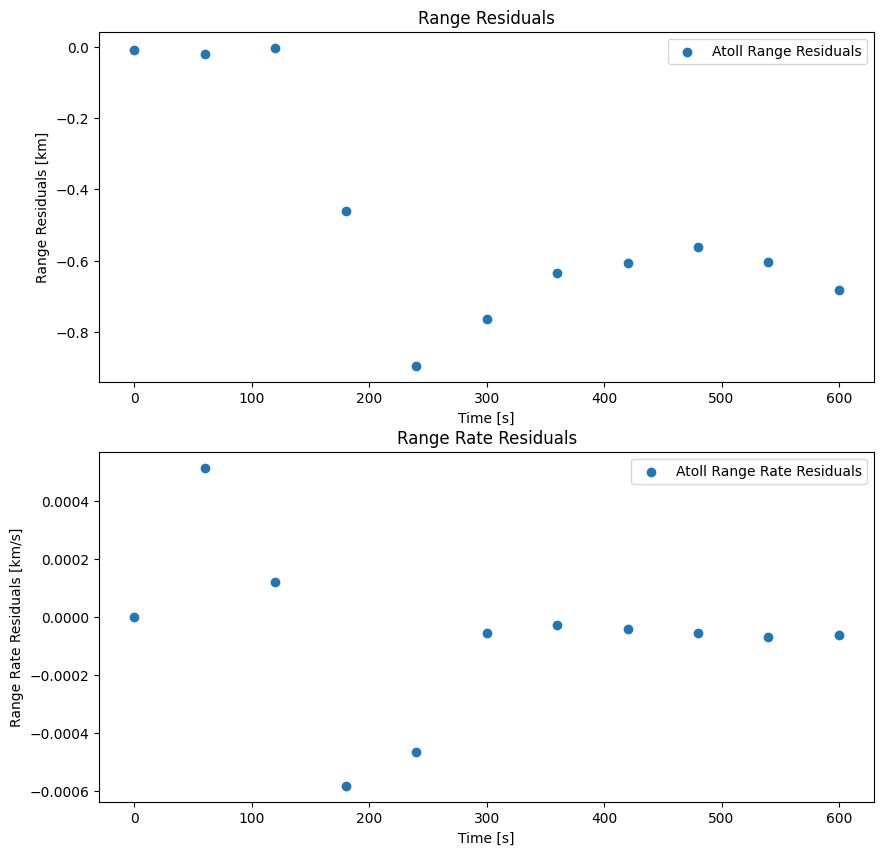

In [8]:
#prefit RMS
df_calc = pd.read_csv('range_rate.csv', names=column_names)


r_calc_Atoll = df_calc['range'][df_calc.index[df_calc['id']==2]]
rr_calc_Atoll = df_calc['range_rate'][df_calc.index[df_calc['id']==2]]

# r_calc_Diego = df_calc['range'][df_calc.index[df_calc['id']==2]]
# rr_calc_Diego = df_calc['range_rate'][df_calc.index[df_calc['id']==2]]
# r_calc_Arecibo = df_calc['range'][df_calc.index[df_calc['id']==3]]
# rr_calc_Arecibo = df_calc['range_rate'][df_calc.index[df_calc['id']==3]]

r_obs_Atoll = obs_df['range'][obs_df.index[obs_df['id']==2][0:11]]
rr_obs_Atoll = obs_df['range_rate'][obs_df.index[obs_df['id']==2][0:11]]

# r_obs_Diego = obs_df['range'][obs_df.index[obs_df['id']==2]]
# rr_obs_Diego = obs_df['range_rate'][obs_df.index[obs_df['id']==2]]
# r_obs_Arecibo = obs_df['range'][obs_df.index[obs_df['id']==3]]
# rr_obs_Arecibo = obs_df['range_rate'][obs_df.index[obs_df['id']==3]]

RMS_Atoll_r = np.sqrt(np.mean((r_obs_Atoll - r_calc_Atoll)**2))
# RMS_Diego_r = np.sqrt(np.mean((r_obs_Diego - r_calc_Diego)**2))
# RMS_Arecibo_r = np.sqrt(np.mean((r_obs_Arecibo - r_calc_Arecibo)**2))

RMS_Atoll_rr = np.sqrt(np.mean((rr_obs_Atoll - rr_calc_Atoll)**2))
# RMS_Diego_rr = np.sqrt(np.mean((rr_obs_Diego - rr_calc_Diego)**2))
# RMS_Arecibo_rr = np.sqrt(np.mean((rr_obs_Arecibo - rr_calc_Arecibo)**2))

#Comparing Pre-fit residuals
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
t_atoll = obs_df['time'][obs_df.index[obs_df['id']==2]][0:11]
t_diego = obs_df['time'][obs_df.index[obs_df['id']==1]]
t_arecibo = obs_df['time'][obs_df.index[obs_df['id']==3]]

print("Atoll Range RMS:", RMS_Atoll_r, "[km]")
print("Atoll Range Rate RMS:", RMS_Atoll_rr,"[km/s]")

ax[0].scatter(t_atoll, r_obs_Atoll - r_calc_Atoll, label='Atoll Range Residuals')
# ax[0].scatter(t_diego, r_obs_Diego - r_calc_Diego, label='Diego Range Residuals')
# ax[0].scatter(t_arecibo, r_obs_Arecibo - r_calc_Arecibo, label='Arecibo Range Residuals')
ax[0].set_title('Range Residuals')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Range Residuals [km]')
ax[0].legend()

ax[1].scatter(t_atoll, rr_obs_Atoll - rr_calc_Atoll, label='Atoll Range Rate Residuals')
# ax[1].scatter(t_diego, rr_obs_Diego - rr_calc_Diego, label='Diego Range Rate Residuals')
# ax[1].scatter(t_arecibo, rr_obs_Arecibo - rr_calc_Arecibo, label='Arecibo Range Rate Residuals')
ax[1].set_title('Range Rate Residuals')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Range Rate Residuals [km/s]')
ax[1].legend()
